<a href="https://colab.research.google.com/github/ravishankar-cloud/machine-learning/blob/main/Behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
! git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [115]:
!ls track

driving_log.csv  IMG


In [116]:
!pip3 install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,MaxPooling2D,Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

In [118]:
datadir='track'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

<ipython-input-118-22dc70de1b18>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [119]:
 def path_leaf(path):
    head,tail=ntpath.split(path)
    return tail

 data['center']=data['center'].apply(path_leaf)
 data['left']=data['left'].apply(path_leaf)
 data['right']=data['right'].apply(path_leaf)
 data.head()



,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


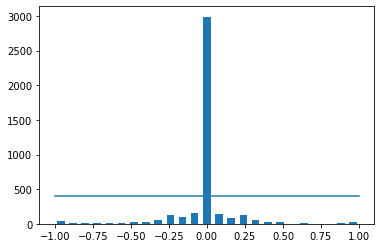

In [120]:
num_bins=25
samples_per_bin=400
hist,bins=np.histogram(data['steering'],num_bins)
center=(bins[:-1] + bins[1:]) * 0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))



total data:  4053
removed 2590
remaining 1463


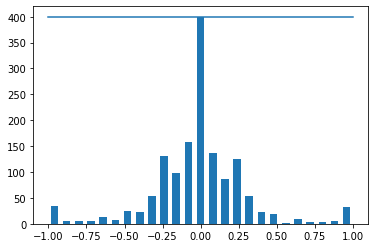

In [121]:
print('total data: ', len(data))
remove_list=[]
for j in range (num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=  list_[
    samples_per_bin:]
  remove_list.extend(list_)

print('removed',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining', len(data))

hist, _=np.histogram(data['steering'],(num_bins))
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))
      

In [122]:
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths, steerings

image_paths, steerings= load_img_steering(datadir +'/IMG',data)
    

In [123]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2, random_state=6)
print("Training samples: {}\nValid samples: {}".format(len(X_train),len(X_valid)) )

Training samples: 1170
Valid samples: 293


Text(0.5, 1.0, 'Validation   set')

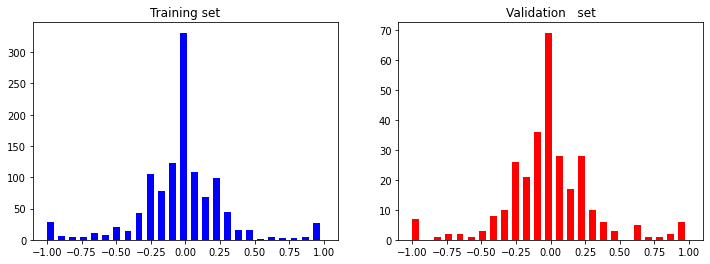

In [124]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train, bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins,width=0.05,color='red')
axes[1].set_title('Validation   set')

In [125]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Augmented image')

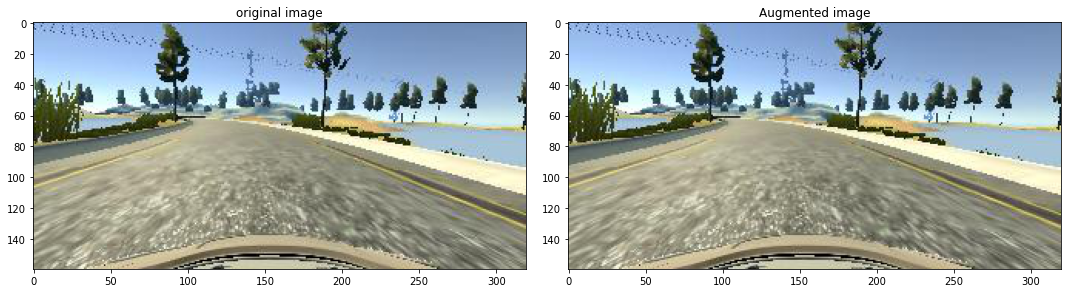

In [126]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image')

axs[1].imshow(original_image)
axs[1].set_title('Augmented image')

In [127]:
def pen(image):
  pen=iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1,0.1)})
  image=pen.augment_image(image)
  return image

Text(0.5, 1.0, 'Penned image')

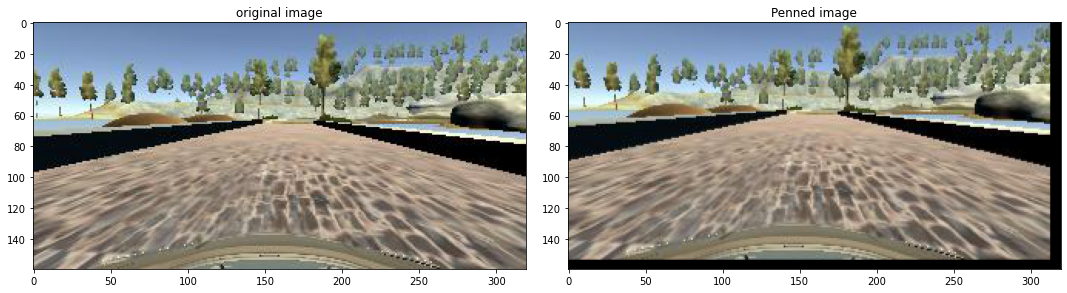

In [128]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
penned_image=pen(original_image)


fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image')

axs[1].imshow(penned_image)
axs[1].set_title('Penned image')

In [129]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2,1.2))
  image=brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'brightness image')

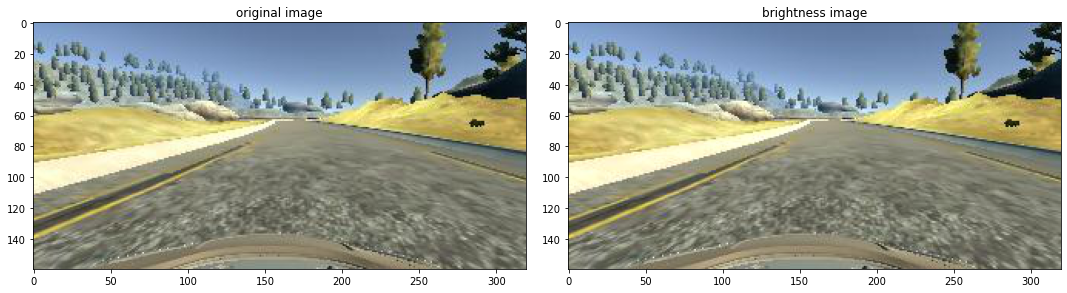

In [130]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('brightness image')

In [131]:
def img_random_flip(image,steering_angle):
  image=cv2.flip(image,1)
  steering_angle=-steering_angle
  return image,steering_angle


Text(0.5, 1.0, 'flipped imageSteering Angle -0.274573')

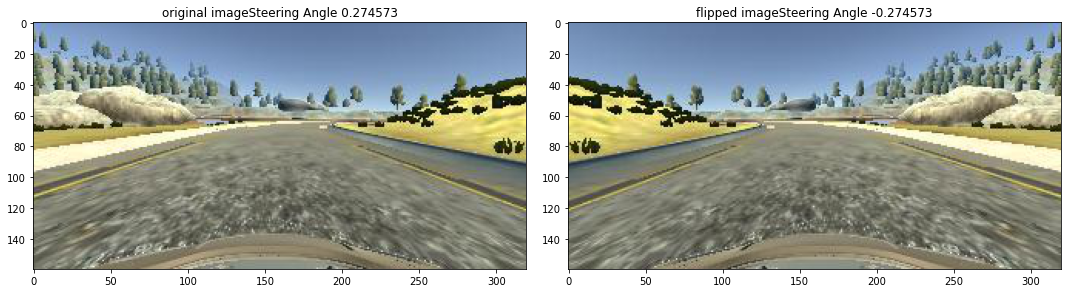

In [132]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]
original_image=mpimg.imread(image)
flipped_image, flipped_steering_angle=img_random_flip(original_image,steering_angle)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image'+ 'Steering Angle ' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('flipped image'+ 'Steering Angle ' + str(flipped_steering_angle))

In [133]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand() < 0.5:
    image=pen(image)
  if np.random.rand() < 0.5:
    image=zoom(image)
  if np.random.rand() < 0.5:
    image=img_random_brightness(image)
  if np.random.rand() < 0.5:
    image,steering_angle=img_random_flip(image,steering_angle)
  return image,steering_angle

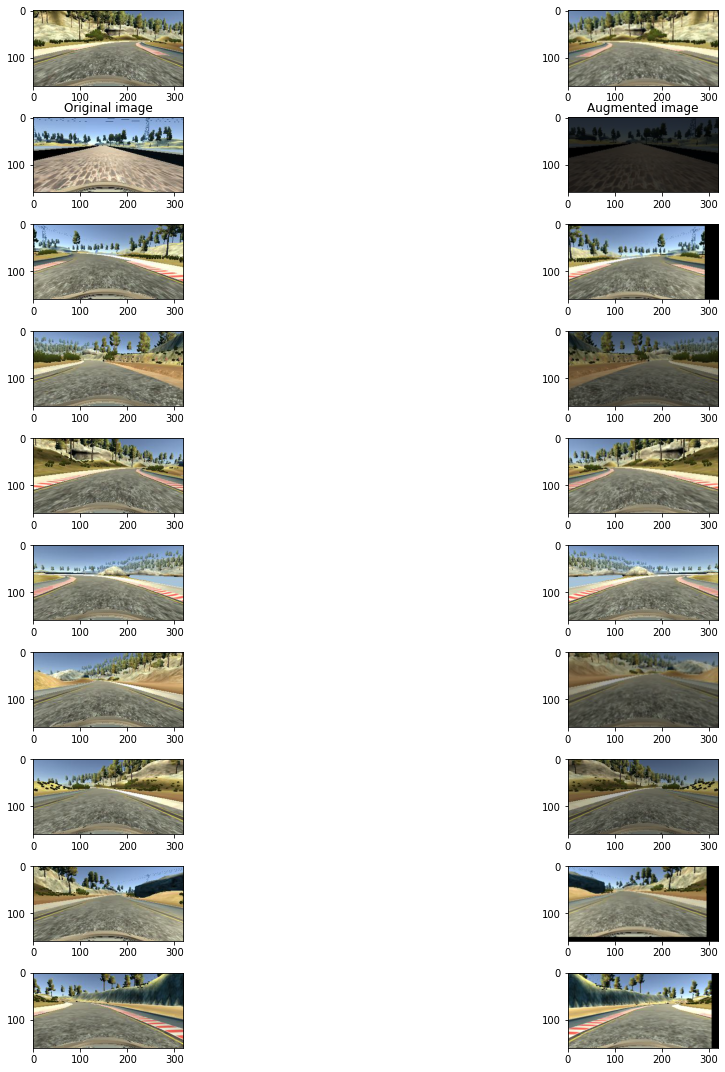

In [134]:
ncol=2
nrow=10
fig,axs =plt.subplots(nrow,ncol,figsize=(15,15))
fig.tight_layout()

for i in range(10):
  randnum=random.randint(0,len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]

  original_image=mpimg.imread(random_image)
  augmented_image, steering=random_augment(random_image,random_steering)

  axs[i][0].imshow(original_image)
  axs[1][0].set_title('Original image')

  axs[i][1].imshow(augmented_image)
  axs[1][1].set_title('Augmented image')

In [135]:
def img_preprocess(img):
  img=img[60:135,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

Text(0.5, 1.0, 'preprocessed_image')

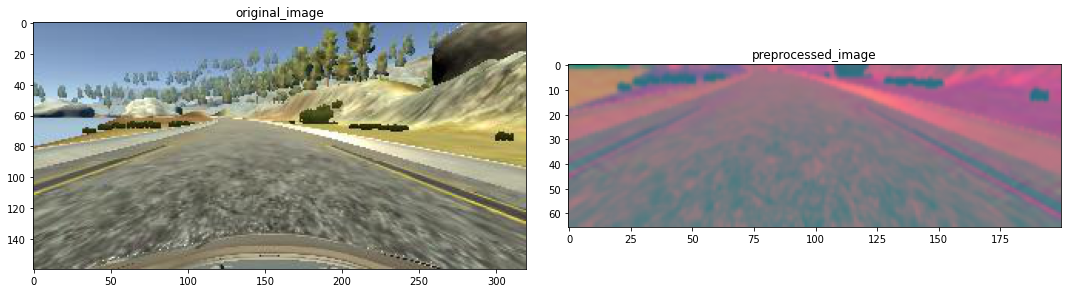

In [136]:
image=image_paths[100]
original_image=mpimg.imread(image)
preprocessed_image=img_preprocess(original_image)
fig,axs=plt.subplots (1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("original_image")
axs[1].imshow(preprocessed_image)
axs[1].set_title("preprocessed_image")


In [137]:
def batch_generator(image_paths,steering_ang,batch_size,istraining):
  while True:
    batch_img=[]
    batch_steering=[]

    for i in range(batch_size):
      random_index=random.randint(0,len(image_paths)-1)

      if istraining:
        im, steering=random_augment(image_paths[random_index],steering_ang[random_index])
      else:
        im=mpimg.imread(image_paths[random_index])
        steering=steering_ang[random_index]
      im=img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img),np.asarray(batch_steering))




Text(0.5, 1.0, 'Validation image')

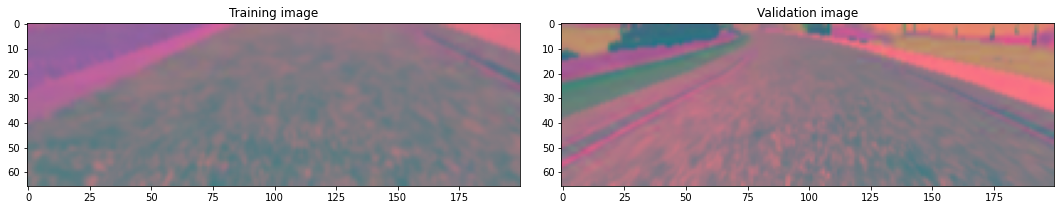

In [138]:
X_train_gen,y_train_gen=next(batch_generator(X_train,y_train,1,1))
X_valid_gen,y_valid_gen=next(batch_generator(X_train,y_train,1,0))

image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training image')

axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation image')

In [139]:
def nvidia_model():
  model=Sequential()
  model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))

  model.add(Convolution2D(64,3,3,activation='elu'))

  model.add(Flatten())

  model.add(Dense(100,activation='elu'))

  model.add(Dense(50,activation='elu'))

  model.add(Dense(10,activation='elu'))

  model.add(Dense(1))

  optimizer =Adam(lr=1e-4)
  model.compile(loss='mse',optimizer=optimizer)
  return model


In [140]:
model=nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 47, 48)        28848     
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 15, 64)         27712     
                                                                 
 conv2d_15 (Conv2D)          (None, 1, 5, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 320)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               32100     
                                                                 
 dense_13 (Dense)            (None, 50)               

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

<ipython-input-141-1380e7fdc075>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/10
197/300 [==================>...........] - ETA: 1:58 - loss: 0.0933

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')